# A Simple Illustration of a 2-Dimensional Groundwater Model
## By: Lejo Flores

## 1. Introduction

This is an example of a 2-dimensional model of landscape evolution (i.e., the evolution of surface topography with time) in which the domain is square. Here we treat the process of hillslope sediment transport as being a diffusive process associated with soil creep. For a diffusive soil creep process, the rate of sediment transport increases in direct proportion to the slope of the landscape; higher slopes mean higher sediment transport. The soil is assumed to be heterogeneous, and isotropic (i.e., there is one value of diffusivity $D$ that is valid everywhere in the domain and in all directions). The purpose of this Jupyter notebook is to illustrate how solution of this 2-D diffusive process is mostly an extension of the previously reviewed 1D diffusion examples into a second dimension. 

Conceptually this model is pretty straightforward - in addition to gradients of elevation in the $x$ direction there is now the need to also compute elevation gradients in the $y$ direction. We will reduce this problem to a suite of discrete linear relationships and use linear algebra, matrix-vector multiplication to solve the system of equations. This requires us to represent, or "flatten," our 2D domain into a column vector. However, where this introduces complications in the numerics is in the "bookkeeping" of keeping track of where in our column vector the cells that were north and south of a central pixel now are after we "flatten" our domain. I illustrate how this works out using a "100s chart" from my daughter's 1st grade classroom, because that's the simplist way to figure out how this works in a general way. 

## 2. A Review of the Math

\begin{equation}
\frac{\partial z}{\partial t} = D\left(\frac{\partial^2z}{\partial x^2}+\frac{\partial^2z}{\partial y^2}\right) + U
\end{equation}

where $z$ is the elevation at a particular point ($x$, $y$), $D$ is the so-called soil diffusivity and $t$ is time. If you look closely, the equation looks very similar to the 1-D diffusion equation that we used as the basis for our permafrost soil temperature model in the previous module. That's because it is. The only appreciable difference is that we are now examining a 2-dimensional system where in we are tracking the change in elevation with time as sediment moves horizontally across the landscape in response to elevation gradients. 

The mathematics of solving this equation numerically are identical to the 1-D problem, the only difference being that we now need to also compute the 2nd derivative of elevation (i.e., the curvature – the slope of the slope) in the $y$-direction as well. The figure below illustrates that we now have a grid that has points in the $x$- and $y$-directions at time $t$, and now the solution at time $t+1$ would just be another grid coming out of the screen: 

<img src='img/5pt_Stencil.png' width='300'>

If we denote $j$ the index of the $x$-direction of the grid and $i$ as the index of the grid in the $y$ direction, we can create the following finite difference solution to the 2-D diffusion equation:

$$
\frac{z_{i,j}^{t+1} - z_{i,j}^{t}}{\Delta t} = D\cdot\frac{z_{i,j-1}^t - 2z_{i,j}^t + z_{i,j+1}^t}{\Delta z^2} + D\cdot\frac{z_{i-1,j}^t - 2z_{i,j}^t + z_{i+1,j}^t}{\Delta z^2}
$$

for an __explicit__ solution and 

$$
\frac{z_{i,j}^{t+1} - z_{i,j}^{t}}{\Delta t} = D\cdot\frac{z_{i,j-1}^{t+1} - 2z_{i,j}^{t+1} + z_{i,j+1}^{t+1}}{\Delta z^2} + D\cdot\frac{z_{i-1,j}^{t+1} - 2z_{i,j}^{t+1} + z_{i+1,j}^{t+1}}{\Delta z^2}
$$

for an __implicit__ solution. This may look more complicated, but ultimately it amounts to some more bookkeeping to keep track of the elements in our vector of elevations are that correspond to the neighboring elements to the North, East, South, and West. I will illustrate this using a 10 x 10 "hundreds" chart from my daughter's first grade class.  

In [10]:
import numpy as np
import matplotlib.pyplot as plt

hi = 100.0 # (m)
D = 2.5 # (m^2/yr)

ti = 0.0 # (yr)
tf = 15000.0 # (yr)
dt = 5 # (yr)

# Uplift rate (m/yr)
U = 0.005 # (m/yr)

# Plotting options
individual_plots = 0 # If 1, individual plot at every output interval, all stacked otherwise
OutputInterval = 3000.0 # (yr)

Nt = (tf - ti)/dt + 1

Noutput = (tf - ti)/OutputInterval + 1

xMax = yMax = 500.0
xMin = yMin = 0.0
Nx = Ny = 50

x = np.linspace(xMin,xMax,Nx)#set up an array of x and y values within the boundaries
y = np.linspace(yMin,yMax,Ny)

dx = x[1] - x[0]
dy = y[1] - y[0]

X, Y = np.meshgrid(x,y)

## 3. Plot the X and Y Grid Meshes

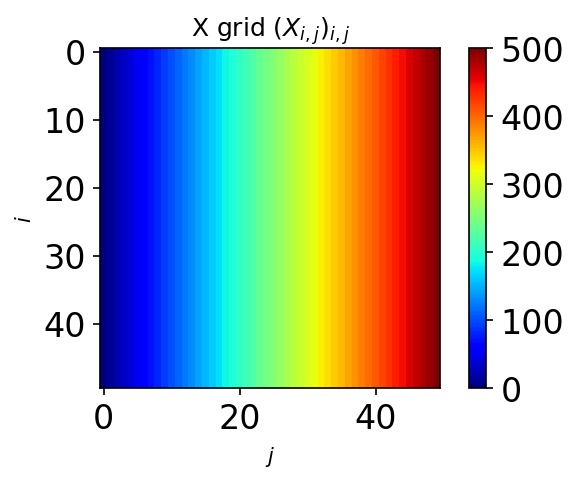

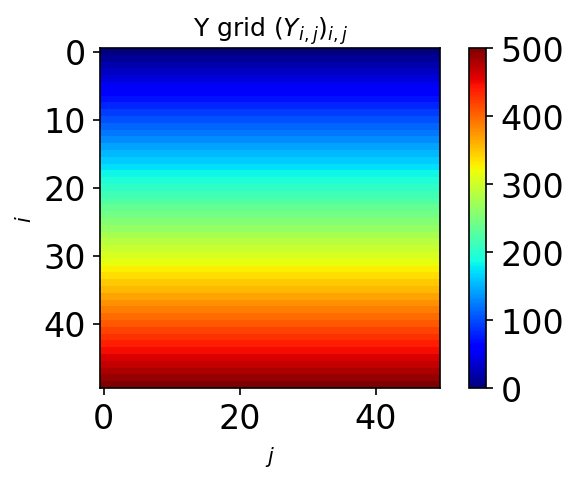

In [11]:
# Plot X grid
plt.figure(1,figsize=(5,3), dpi=150)
plt.title("X grid $(X_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(X,cmap="jet")
plt.colorbar()
plt.show()

# Plot Y grid
plt.figure(2,figsize=(5,3), dpi=150)
plt.title("Y grid $(Y_{i,j})_{i,j}$")
plt.xlabel(r"$j$")
plt.ylabel(r"$i$")
plt.imshow(Y,cmap="jet")
plt.colorbar()
plt.show()


## 4. Compute the Stability Variable 

In [12]:
alpha = D*dt/dx**2
print("alpha = ",alpha)
print("dt = ",dt)
print("dx = ",dx)
if alpha >= 0.5:
    raise Exception("Stability criteria error! Either decrease dt or increase dx!")

alpha =  0.12005000000000002
dt =  5
dx =  10.204081632653061


## 5. Setup the Solver Matrix 

The most confusing part of the 2-D problem is the bookkeeping. We need a systematic way way to keep track of the location of the neighboring cells/pixels in our domain so we can compute finite differences. We will assume that our domain is rectangular and 10 cells in the $x$-direction by 10 cells in the $y$-direction for a total of 100 cells in the domain. And each cell will have a unique ID that is associated with the order of the cell if you counted all of them, starting with the upper left cell and moving to the right. This domain would look a lot like the chart below: 

<img src='img/100sChart.png' width='600'>

Because the domain is 10 cells x 10 cells, if we consider a cell the cells to the left and right of that cell (i.e., moving in the $x$ direction) could be accessed by decreasing (moving West) or increasing (moving East) the number in the "ones place" of the cell ID by one unit. Conversely, considering the cells above and below that cell (i.e., moving in the $y$ direction) could be accessed by decreasing (moving North) or increasing (moving South) the number in the "tens place" of the cell ID by one unit. For cell number 45 we can visualize this as,

<img src='img/100sChartStencilEx.png' width='600'>

So, if we were to compute the 2nd order finite difference difference of the elevation of cell 45, we would compute it as follows:

$$
\frac{\partial^2 z}{\partial x^2} + \frac{\partial^2 z}{\partial y^2} \approx \frac{z_{44} - 2z_{45} + z_{46}}{\Delta z^2} + \frac{z_{35} - 2z_{45} + z_{55}}{\Delta z^2}
$$

Note that increasing the number in the tens place to access the cell to the North/South of each cell __only__ works for our 10 x 10 cell domain. Generally, for a rectangular domain where the cells are identified by their counting order, we would access the cell to the North/South of our center cell by subtracting/adding, respectively, the number of cells in the $x$-dimension in our domain. In our example above, this happened to be 10. You can convince yourself this is correct for a 5 x 5 domain below:

$$
\mathbf{z} = 
\begin{bmatrix}
z_1 & z_2 & z_3 & z_4 & z_5 \\
z_6 & z_7 & z_8 & z_9 & z_{10} \\
z_{11} & z_{12} & z_{13} & z_{14} & z_{15} \\
z_{16} & z_{17} & z_{18} & z_{19} & z_{20} \\
z_{21} & z_{22} & z_{23} & z_{24} & z_{25}
\end{bmatrix}
$$

How would you approximate $\frac{\partial z_{13}^2}{\partial x^2} + \frac{\partial z_{13}^2}{\partial y^2}$ using a finite difference approach?

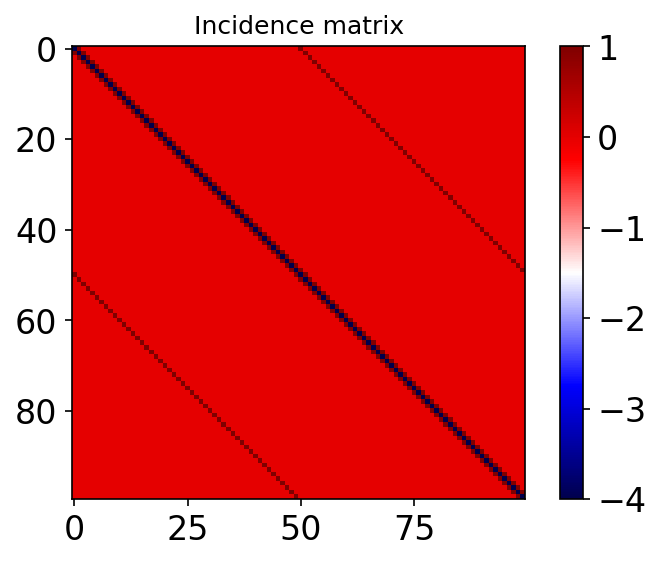

In [13]:
N = Nx*Ny

ind = np.linspace(0,N-1,N)
Ind = np.linspace(0,N-1,N).reshape((Ny,Nx))

Delta2 = np.matrix(np.diagflat(-4.0*np.ones((int(N),1)),k=0) + np.diagflat(np.ones((int(N-1),1)),k=1) \
    + np.diagflat(np.ones((int(N-1),1)),k=-1) + np.diagflat(np.ones((int(N-Nx),1)),k=int(Nx)) \
    + np.diagflat(np.ones((int(N-Ny),1)),k=-(int(Ny))))

plt.figure(3,figsize=(6,4), dpi=150)
plt.title("Incidence matrix")
plt.imshow(Delta2[0:(2*int(Ny)),0:(2*int(Nx))],cmap="seismic")
plt.colorbar()
plt.show()

## 6. Setup the Boundary Conditions

In this problem, the boundary conditions are a little more complex. We will assume that the elevation at the corder of our square domain remain fixed throughout the simulation. But the rest of the area along the edges of the domain can evolve. 

What we need to do to allow this is actually first solve the 1-D problem once (using the same $\Delta x$, $D$, $\Delta t$, and simulation duration) on the edges of the domain with fixed edges, and then use that solution at every time step along ___all four___ edges of the domain. 

In [14]:
NBound = np.array(Ind[0,:])#set fixed boundary conditions
SBound = np.array(Ind[-1,:])
WBound = np.array(Ind[:,0])
EBound = np.array(Ind[:,-1])

# Now compute the boundary conditions on the sides of the domain as the temporal evolution of a !D
# profile in response to a lowering of head on 1-side of the domain

Delta2_1D = np.matrix(np.diagflat(-2.0*np.ones((int(Nx),1)),k=0) + np.diagflat(np.ones((int(Nx-1),1)),k=1) \
    + np.diagflat(np.ones((int(Nx-1),1)),k=-1))

h0_1D = hi*np.ones(shape=(int(Nx),1))

H_1D = np.matrix(np.zeros(shape=(int(Nx),int(Nt))))

H_1D[:,0] = np.matrix(h0_1D)

for i in range(1,int(Nt)):
    hinit_1D = H_1D[:,i-1] 
        
    hnext_1D = hinit_1D + alpha*Delta2_1D*hinit_1D + U*dt
    hnext_1D[0] = hi
    hnext_1D[-1] = hi

    H_1D[:,i] = hnext_1D[:,0]

## 7. Running the Model

Now we need to run the model. Here we use an explicit approach to the solution, but we pose it as a linear algebra matrix-vector multiplication (i.e., we don't have to invert the matrix $\mathbf{A}$. We will create a 3-D plot at fixed intervals along the simulation... it's too much to visualize each timestep. You can control how often plots are created using the variable `OutputInterval`. 

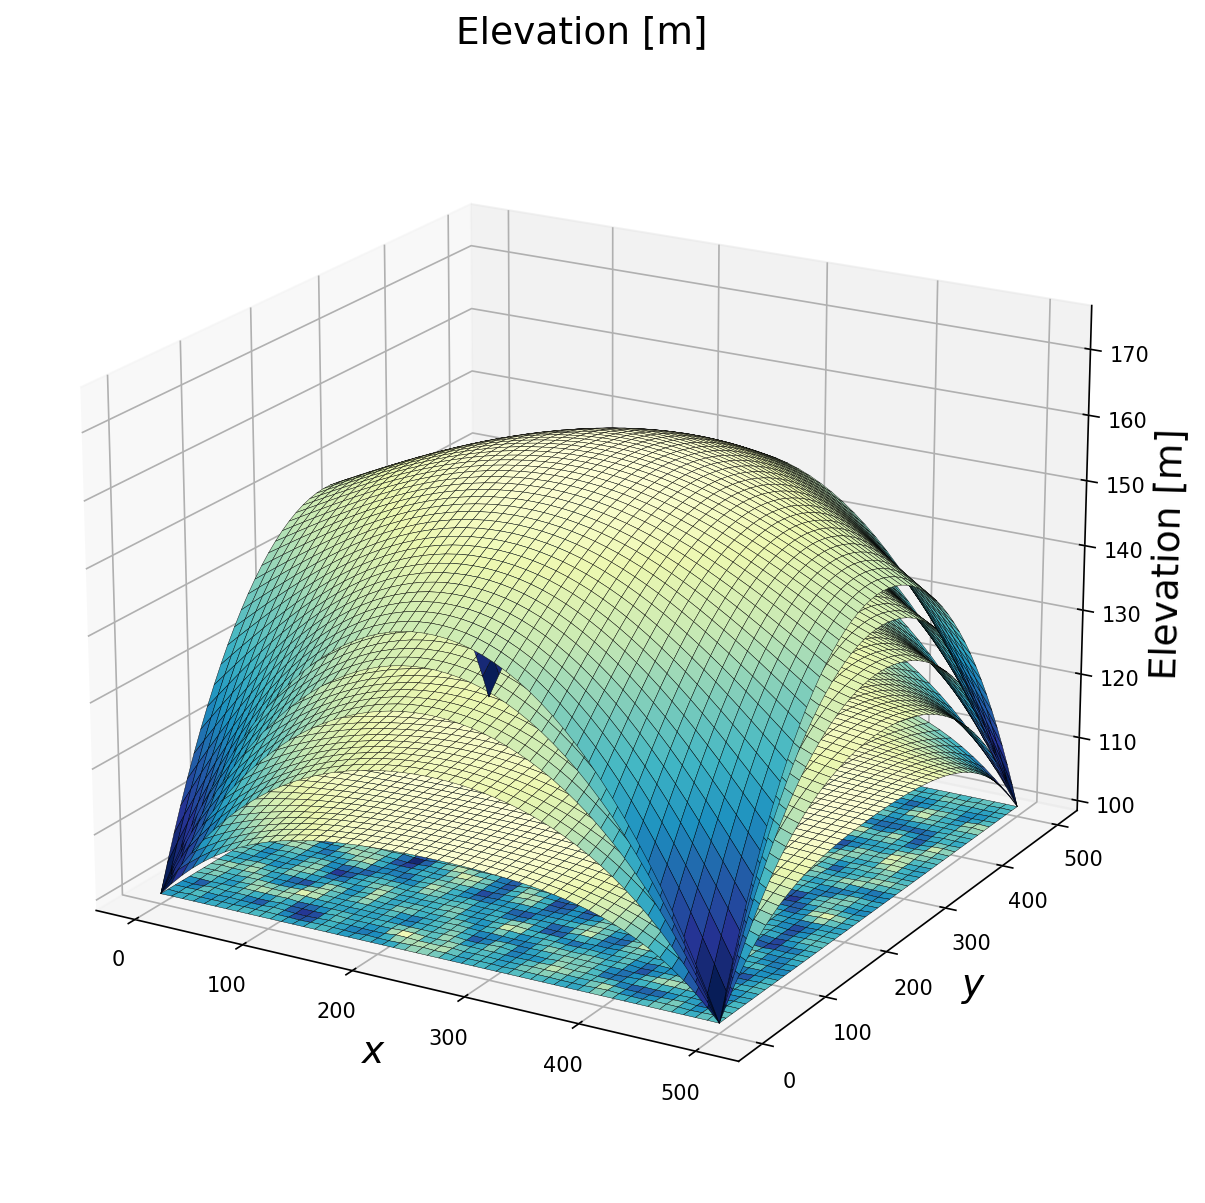

In [6]:
import matplotlib as mpl

h0 = hi*np.ones(shape=(int(N),1)) + 0.1*np.random.randn(N,1)
hnext = np.matrix(h0)

figcounter = 1

for i in range(1,int(Nt)):
    hinit = hnext + U*dt
    
    hnext = hinit + alpha*Delta2*hinit 

    hnext[NBound.astype(int)] = H_1D[:,i]
    hnext[EBound.astype(int)] = H_1D[:,i] 
    hnext[SBound.astype(int)] = H_1D[:,i]
    hnext[WBound.astype(int)] = H_1D[:,i]
    
    if(i==1) or ((i*dt) % OutputInterval == 0):
        H = np.reshape(hnext,(Ny,Nx))

        if(individual_plots==1):
            fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title("Elevation $h_{i,j}$ at t = %s"%(i*dt), fontsize=18)
        else:
            if(figcounter==1):
                fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(14,10), dpi=150)
            ax.set_title('Elevation [m]', fontsize=18)
        ax.set_xlabel('$x$', fontsize=18)
        ax.set_ylabel('$y$', fontsize=18)
        ax.set_zlabel('Elevation [m]', fontsize=18)
        ax.set_xticks(np.arange(xMin,xMax+1.0,(xMax-xMin)/5))
        ax.set_yticks(np.arange(yMin,yMax+1.0,(yMax-yMin)/5))
        mpl.rcParams['xtick.labelsize'] = 16
        mpl.rcParams['ytick.labelsize'] = 16
        ax.plot_surface(X,Y,H,cmap='YlGnBu_r',linewidth=0.2,edgecolors='k')
        ax.set_zlim(hi, hi+U*dt*Nt)
        ax.view_init(elev=20.0)
        figcounter = figcounter + 1

plt.show()

### 